# Handwritten Character Recognition Model

In [1]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow.keras.backend as K
import warnings
from imutils.contours import sort_contours
import cv2 as cv
import imutils

C:\Users\prath\anaconda3\envs\pythonProject\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\prath\anaconda3\envs\pythonProject\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\prath\anaconda3\envs\pythonProject\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\prath\anaconda3\envs\pythonProject\lib\s

## Loading the dataset
The two fucntions below are used to load the datasets to train the model. The datasets used here are MNIST dataset which has already been split into training and testing set and the NIST Special Database 19 which is a similar to MNIST but contains letters instead of numbers. Both the datasets are of CSV variants to maintain a common dimension between them to ease the integration process. 

In [2]:
def load_az_dataset(path):
    dataset = pd.read_csv(path).astype('float32')
    dataset.rename(columns={'0': 'label'}, inplace=True)

    data = dataset.drop('label', axis=1)
    labels = dataset['label']

    return data, labels

In [3]:
def load_digit_dataset(path1, path2):
    dataset = pd.read_csv(path1).astype('float32')
    dataset.rename(columns={'0': 'label'}, inplace=True)

    data1 = dataset.drop('label', axis=1)
    labels1 = dataset['label']

    dataset = pd.read_csv(path2).astype('float32')
    dataset.rename(columns={'0': 'label'}, inplace=True)

    data2 = dataset.drop('label', axis=1)
    labels2 = dataset['label']

    data = data1.append(data2)
    labels = labels1.append(labels2)

    return data, labels

## The training model
For this project, due to the presence of images and their classification, Convolutional Neural Networks have been used. The model contains four convulutions followed by two hidden layers and output layer. The activation for the convolutions and the hidden layers is 'relu' and for the ouput layer, it is 'softmax' as it helps with the multi-class classification.

In [4]:
def build(width, height, depth, classes):
    model = tf.keras.models.Sequential([
        # First two convolutions
        tf.keras.layers.Conv2D(32, (3, 3), input_shape=(width, height, depth), activation='relu'),
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
        tf.keras.layers.MaxPool2D(2, 2),

        # Next two convolutions
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPool2D(2, 2),

        # Flatten the results
        tf.keras.layers.Flatten(),

        # Two 256 neuron hidden layers
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dense(256, activation='relu'),

        # Output layer with 36 classes for all digits and letters
        tf.keras.layers.Dense(classes, activation='softmax')
    ])

    return model

In [5]:
# Import the datasets from load_dataset.py file
print("[INFO] loading the dataset...")
(alpha_data, alpha_labels) = load_az_dataset('A_Z Handwritten Data.csv')
(digit_data, digit_labels) = load_digit_dataset('mnist_train.csv', 'mnist_test.csv')
print("dataset loaded successfully.")

[INFO] loading the dataset...
dataset loaded successfully.


## Combining the datasets
Once the datasets are loaded, the two datasets are combined together so that they can be used to train the model. The labels of the NIST dataset are increased by a value of 10 to prevent overlapping with the MNIST datatset. It is then expanded and normalised. 

To combine the two datasets, 'vstack' and 'hstack' functions of the numpy library are used.

In [6]:
# Change the labels of the alphabet dataset to prevent overlapping
alpha_labels += 10

# Combine the two datasets into one
data = np.vstack([alpha_data, digit_data])
labels = np.hstack([alpha_labels, digit_labels])

# Expand the dimensions and normalize the data
data = np.expand_dims(data, axis=-1)
data = data / 255.0

## Splitting the dataset into to training and testing sets
The data is split using the 'train_test_split' function of the sklearn library. Once it is split, the train and test data are reshaped based on whether it is channel first or not. To check the channel, we're using keras.backend library. 

In [7]:
# Split the dataset into training and testing data
(train_data, test_data, train_labels, test_labels) = train_test_split(
    data,
    labels,
    test_size=0.25,
    random_state=42
)

# Reshape the data into 3 dimensions. keras.backend is used to adjust teh data based on the channel ordering
if K.image_data_format() == 'channels_first':
    train_data = train_data.reshape(train_data.shape[0], 1, 28, 28)
    test_data = test_data.reshape(test_data.shape[0], 1, 28, 28)
    input_shape = (1, 28, 28)
else:
    train_data = train_data.reshape(train_data.shape[0], 28, 28, 1)
    test_data = test_data.reshape(test_data.shape[0], 28, 28, 1)
    input_shape = (28, 28, 1)

In [8]:
# Image augmentation
aug = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    shear_range=0.2,
    fill_mode='nearest'
)

## Training the model.
Now that the data is processed and ready, we can use it to train the model. The input shape for the model is (28, 28, 1) and the optimizer used here is 'Stochastic Gradient Descent'. This is mainly due to the size of the dataset and the computational speed of the optimizer. For the loss function, the 'Sparse Categorical Cross-Entropy' function is used.

In [9]:
# Import the model and build it
model = build(28, 28, 1, 36)

# Compile the model
opt = tf.keras.optimizers.SGD(lr=0.01, decay=0.01 / 50)
model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# To filter out unnecessary warnings
warnings.filterwarnings('ignore')

# Fitting the model
print("[INFO] training the model...")
history = model.fit(
    aug.flow(train_data, train_labels, batch_size=128),
    validation_data=(test_data, test_labels),
    steps_per_epoch=len(train_data) // 128,
    epochs=50,
    verbose=1
)

# saving the model
print("[INFO] serializing network...")
model.save("ocr", save_format="h5")

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
[INFO] training the model...
Epoch 1/50
2592/2592 [==============================] - 358s 138ms/step - loss: 2.3232 - acc: 0.3761 - val_loss: 0.7191 - val_acc: 0.7907
Epoch 2/50
2592/2592 [==============================] - 338s 131ms/step - loss: 1.0495 - acc: 0.6989 - val_loss: 0.4393 - val_acc: 0.8701
Epoch 3/50
2592/2592 [==============================] - 337s 130ms/step - loss: 0.7859 - acc: 0.7714 - val_loss: 0.3538 - val_acc: 0.8954
Epoch 4/50
2592/2592 [==============================] - 338s 130ms/step - loss: 0.6793 - acc: 0.8016 - val_loss: 0.3088 - val_acc: 0.9080
Epoch 5/50
2592/2592 [==============================] - 339s 131ms/step - loss: 0.6215 - acc: 0.8179 - val_loss: 0.2870 - val_acc: 0.9138
Epoch 6/50
2592/2592 [==============================] - 339s 131ms/step - loss: 0.5782 - acc: 0.8300 - val_loss: 0.2781 - val_acc: 0.9167
Epoch 7/50
2592/2592 [===

## Plotting the accuracy and loss of the model
Matplotlib is used here to plot the training and validation accuracy as well the respective losses of the model. This will give more insight into the performance over time of the model.

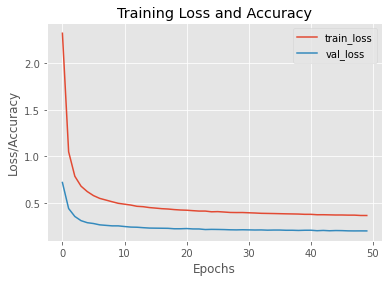

In [10]:
# construct a plot that plots and saves the training history
N = np.arange(0, 50)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, history.history["loss"], label="train_loss")
plt.plot(N, history.history["val_loss"], label="val_loss")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper right")
plt.show()

## Reading the image
In this section, code relevant to reading the image file and isolating the text for classification is done. This is done by detecting the contours of the text and looping over each contour, extracting the character, feeding to the model and labelling it. The label is then returned to the image and stored there.

To perform all these operations, the 'opencv' library is extensively used.

In [9]:
# loading the input image from disk, converting it to grayscale, and blurring it to reduce noise
image = cv.imread('ocr4.jpg')
gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
blurred = cv.GaussianBlur(gray, (5, 5), 0)
    
# performing edge detection, finding contours in the edge map, and sorting the resulting contours from left-to-right
edged = cv.Canny(blurred, 30, 150)
cnts = cv.findContours(edged.copy(), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
cnts = sort_contours(cnts, method="left-to-right")[0]

# initializing the list of contour bounding boxes and associated characters that we'll be OCR'ing
chars = []

In [10]:
# loop over the contours
for c in cnts:
    # compute the bounding box of the contour
    (x, y, w, h) = cv.boundingRect(c)
    # filter out bounding boxes, ensuring they are neither too small
    # nor too large
    if (w >= 5 and w <= 150) and (h >= 15 and h <= 120):
        # extract the character and threshold it to make the character
        # appear as *white* (foreground) on a *black* background, then
        # grab the width and height of the thresholded image
        roi = gray[y:y + h, x:x + w]
        thresh = cv.threshold(roi, 0, 255, cv.THRESH_BINARY_INV | cv.THRESH_OTSU)[1]
        (tH, tW) = thresh.shape
        # if the width is greater than the height, resize along the width dimension
        if tW > tH:
            thresh = imutils.resize(thresh, width=28)
        # otherwise, resize along the height
        else:
            thresh = imutils.resize(thresh, height=28)
            
        # re-grab the image dimensions (now that its been resized)
        # and then determine how much we need to pad the width and
        # height such that our image will be 28x28
        (tH, tW) = thresh.shape
        dX = int(max(0, 28 - tW) / 2.0)
        dY = int(max(0, 28 - tH) / 2.0)
        # pad the image and force 28x28 dimensions
        padded = cv.copyMakeBorder(thresh, top=dY, bottom=dY, left=dX, right=dX, borderType=cv.BORDER_CONSTANT, 
                                    value=(0, 0, 0))
        padded = cv.resize(padded, (28, 28))
        # prepare the padded image for classification via our handwriting OCR model
        padded = padded.astype("float32") / 255.0
        padded = np.expand_dims(padded, axis=-1)
        # update our list of characters that will be OCR'd
        chars.append((padded, (x, y, w, h)))

In [11]:
# extract the bounding box locations and padded characters
boxes = [b[1] for b in chars]
chars = np.array([c[0] for c in chars], dtype="float32")

# OCR the characters using our handwriting recognition model
model = tf.keras.models.load_model('ocr')
preds = model.predict(chars)

# define the list of label names
labelNames = '0123456789'
labelNames += 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
labelNames = [l for l in labelNames]

In [12]:
# loop over the predictions and bounding box locations together
for (pred, (x, y, w, h)) in zip(preds, boxes):
    # find the index of the label with the largest corresponding probability, then extract the probability and label
    i = np.argmax(pred)
    prob = pred[i]
    label = labelNames[i]
    
    # draw the prediction on the image
    print("[INFO] {} - {:.2f}%".format(label, prob * 100))
    cv.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
    cv.putText(image, label, (x - 10, y - 10), cv.FONT_HERSHEY_SIMPLEX, 1.2, (0, 255, 0), 2)
    
    # show the image
    cv.imshow("Image", image)
    cv.waitKey(5000)
    
cv.destroyAllWindows()

[INFO] A - 40.22%
[INFO] C - 91.31%
[INFO] 9 - 86.77%
[INFO] 3 - 99.89%
[INFO] 6 - 52.76%
[INFO] K - 93.49%
[INFO] S - 97.90%
